## Context

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is negative and label '0' denotes the tweet is positive, your objective is to predict the labels on the test dataset.

### Import Library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

plt.style.use('seaborn')

### Load Dataset

In [2]:
train = pd.read_csv('../Datasets/dataset sentiment twit/train.csv')
test = pd.read_csv('../Datasets/dataset sentiment twit/test.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
# shape of data
print(train.shape, test.shape)

(31962, 3) (17197, 2)


In [6]:
# information of dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
# Statistic descriptive of dataset
train.describe() # number 

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [8]:
train.describe(exclude='number') # object/string

,tweet
count,31962
unique,29530
top,#model i love u take with u all the time in ...
freq,319


In [9]:
# Check total of label
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

This total of label have highly imbalanced data. We can use oversampling or downsampling to solve this problem

### Data Preproccessing, Exploratory Data Analysis, & Data Visualization

#### - Drop column id in train dataset

In [10]:
train.drop(columns='id', inplace=True)
train.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


#### - Add column length of tweet

In [11]:
train['length_of_sent'] = [len(train.tweet[word]) for word in range(len(train))]
train

,label,tweet,length_of_sent
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39
...,...,...,...
31957,0,ate @user isz that youuu?ðððððð...,68
31958,0,to see nina turner on the airwaves trying to...,131
31959,0,listening to sad songs on a monday morning otw...,63
31960,1,"@user #sikh #temple vandalised in in #calgary,...",67


#### - Check missing value & duplicate data

In [12]:
# missing value
train.isna().sum()

label             0
tweet             0
length_of_sent    0
dtype: int64

In [13]:
test.isna().sum()

id       0
tweet    0
dtype: int64

In [14]:
# duplicate data
train[train.duplicated(subset=['tweet'])]

,label,tweet,length_of_sent
46,0,#model i love u take with u all the time in ...,86
96,0,#model i love u take with u all the time in ...,86
117,0,#model i love u take with u all the time in ...,86
162,0,#model i love u take with u all the time in ...,86
218,0,#model i love u take with u all the time in ...,86
...,...,...,...
31886,0,100 amazing health benefits of cucumbers! #...,73
31904,0,#model i love u take with u all the time in ...,86
31930,1,@user #feminismiscancer #feminismisterrorism #...,97
31951,0,i've just posted a new blog: #secondlife #lone...,57


#### - Total of label

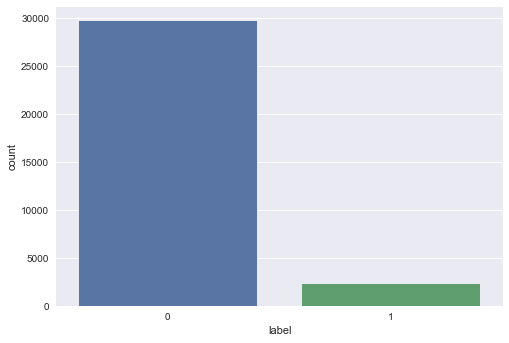

In [15]:
sns.countplot(x='label', data=train);

#### - Avarage length of sentence

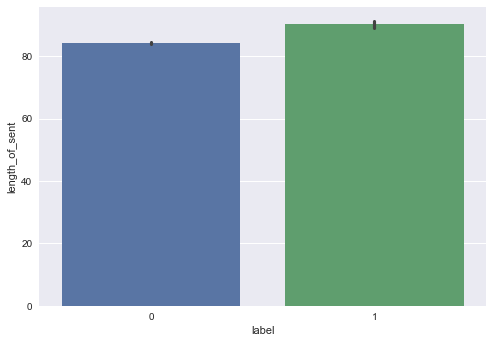

In [21]:
sns.barplot(x='label', y='length_of_sent', data=train);

#### - Distributon plot for label positive & negative

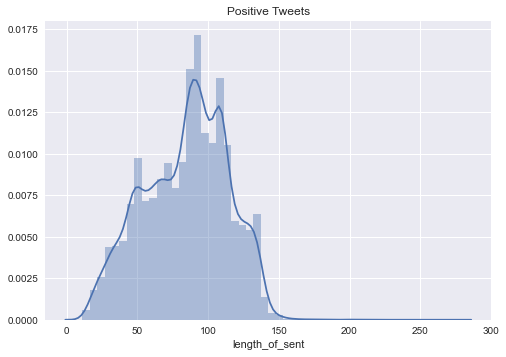

In [16]:
sns.distplot(train[train['label']==0]['length_of_sent']).set(title='Positive Tweets');

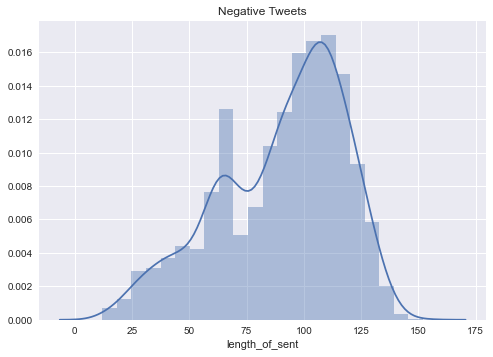

In [17]:
sns.distplot(train[train['label']==1]['length_of_sent']).set(title='Negative Tweets');

#### - Cleaning column tweet

In [32]:
cleaned_tweet = []
def cleaned_text():
    for i in range(0, len(train)):
        text = re.sub('[^a-zA-Z#]', ' ', train['tweet'][i])
        text = text.lower()
        text = text.split()
        english_stopwords = stopwords.words('english')
        text = [word for word in text if not word in english_stopwords]
        text = ' '.join(text)
        cleaned_tweet.append(text)
    return cleaned_tweet
        
    
cleaned_text()

['user father dysfunctional selfish drags kids dysfunction #run',
 'user user thanks #lyft credit use cause offer wheelchair vans pdx #disapointed #getthanked',
 'bihday majesty',
 '#model love u take u time ur',
 'factsguide society #motivation',
 'huge fan fare big talking leave chaos pay disputes get #allshowandnogo',
 'user camping tomorrow user user user user user user user danny',
 'next school year year exams think #school #exams #hate #imagine #actorslife #revolutionschool #girl',
 'love land #allin #cavs #champions #cleveland #clevelandcavaliers',
 'user user welcome #gr',
 '#ireland consumer price index mom climbed previous may #blog #silver #gold #forex',
 'selfish #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreaking #values #love #',
 'get see daddy today # days #gettingfed',
 'user #cnn calls #michigan middle school build wall chant #tcot',
 'comment #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphi

In [34]:
# Make new column for cleaned_tweet
train['cleaned_tweet'] = cleaned_tweet
train['len_of_sent_clean'] = [len(train['cleaned_tweet'][word]) for word in range(len(train))]
train.head()

,label,tweet,length_of_sent,cleaned_tweet,len_of_sent_clean
0,0,@user when a father is dysfunctional and is s...,102,user father dysfunctional selfish drags kids d...,61
1,0,@user @user thanks for #lyft credit i can't us...,122,user user thanks #lyft credit use cause offer ...,90
2,0,bihday your majesty,21,bihday majesty,14
3,0,#model i love u take with u all the time in ...,86,#model love u take u time ur,28
4,0,factsguide: society now #motivation,39,factsguide society #motivation,30


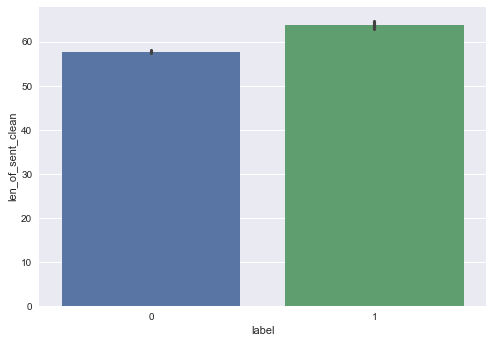

In [35]:
sns.barplot(x='label', y='len_of_sent_clean', data=train);

#### - Text Processing

In [43]:
X = train['cleaned_tweet'].values
y = train['label'].values

# Tokenizing
count_vec = CountVectorizer()
X_train_vec = count_vec.fit_transform(X)

tf_trans = TfidfTransformer()
X_train_idf = tf_trans.fit_transform(X_train_vec)
print(X_train_vec.shape, X_train_idf.shape)

(31962, 37498) (31962, 37498)


#### - Model Building